In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, SCORERS, mean_squared_error, accuracy_score, f1_score, ConfusionMatrixDisplay
from imblearn.datasets import make_imbalance
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import RandomOverSampler

In [3]:
posts_df = pd.read_csv('./Data/posts_scores_dates.csv')

In [4]:
X = posts_df['title']
y = posts_df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

## Regression Models to predict score

#### Baselines

In [5]:
baseline = np.full_like(y_test, y_train.median())

print(mean_squared_error(y_test, baseline, squared = False))

print(accuracy_score(y_test, baseline))

889.3682643293197
0.01778436457947388


#### Basic KNN Regressor

In [6]:
pipe_knn = Pipeline([
    ('cv', CountVectorizer()),
    ('knn', KNeighborsRegressor())
])

In [7]:
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('knn', KNeighborsRegressor())])

In [8]:
print(pipe_knn.score(X_train, y_train))
print(pipe_knn.score(X_test, y_test))

0.1883731025654961
-0.2697590813831401


In [9]:
mean_squared_error(y_train, pipe_knn.predict(X_train), squared = False)

1075.0297667838522

In [10]:
mean_squared_error(y_test, pipe_knn.predict(X_test), squared = False)

992.9478033165451

These numbers are both a bit worse than baseline, but the model is overfit and still has a large error

#### Basic Logistic Regressor

In [11]:
pipe_lr = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])

In [12]:
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_train, y_train), pipe_lr.score(X_test, y_test)

(0.4967885375494071, 0.18303075213041867)

In [13]:
print(mean_squared_error(y_train, pipe_lr.predict(X_train), squared = False))
print(mean_squared_error(y_test, pipe_lr.predict(X_test), squared = False))

1170.4576042977799
890.5628898833294


The model is underperforming, but exceeds the baseline accuracy

#### Basic Random Forest Regressor

In [14]:
pipe_rf = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestRegressor())
])

In [15]:
pipe_rf.fit(X_train, y_train)
pipe_rf.score(X_train, y_train), pipe_rf.score(X_test, y_test)

(0.7468904995170231, -0.6353309400911842)

In [16]:
print(mean_squared_error(y_train, pipe_rf.predict(X_train), squared = False))
print(mean_squared_error(y_test, pipe_rf.predict(X_test), squared = False))

600.3389170844509
1126.856417461666


The model is outperforming the baseline, but is overfit

#### Basic Extra Trees Regressor

In [17]:
pipe_et = Pipeline([
    ('cv', CountVectorizer()),
    ('et', ExtraTreesRegressor(n_jobs=-1))

])

In [18]:
pipe_et.fit(X_train, y_train)
pipe_et.score(X_train, y_train), pipe_et.score(X_test, y_test)

(0.9247702493419087, -1.3325938426692319)

## Classification Models to predict if viral (top 2% of scores)

First create a function to pull all metrics

In [12]:
def get_metrics(function):
    print(f'The training balanced accuracy score is {balanced_accuracy_score(y_train, function.predict(X_train))}')
    print(f'The testing balanced accuracy score is {balanced_accuracy_score(y_test, function.predict(X_test))}')
    print(f'The training f1 score is {f1_score(y_train, function.predict(X_train))}')
    print(f'The testing f1 score is {f1_score(y_test, function.predict(X_test))}')
    print(f'The training accuracy score is {accuracy_score(y_train, function.predict(X_train))}')
    print(f'The testing accuracy score is {accuracy_score(y_test, function.predict(X_test))}')

Train Test Split

In [8]:
X = posts_df['title']
y = posts_df['viral']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, stratify=y)

#### baseline

In [21]:
posts_df['viral'].value_counts(normalize=True)

0    0.979991
1    0.020009
Name: viral, dtype: float64

In [22]:
baseline_preds = np.full_like(y_test, 0)

In [23]:
print(f'The baseline balanced accuracy score is {balanced_accuracy_score(y_test, baseline_preds)}')
print(f'The baseline f1 score is {f1_score(y_test, baseline_preds)}')
print(f'The baseline accuracy score is {accuracy_score(y_test, baseline_preds)}')

The baseline balanced accuracy score is 0.5
The baseline f1 score is 0.0
The baseline accuracy score is 0.9799925898480919


#### Basic Logistic Regression

In [24]:
pipe_lrc = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=1000, random_state=20))
])

pipe_lrc.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(max_iter=1000, random_state=20))])

In [25]:
get_metrics(pipe_lrc)

The training balanced accuracy score is 0.5216049382716049
The testing balanced accuracy score is 0.5090702233424351
The training f1 score is 0.08284023668639053
The testing f1 score is 0.03571428571428571
The training accuracy score is 0.9808547430830039
The testing accuracy score is 0.9799925898480919


The model is slightly out performing the baseline on all metrics

#### Logistic Regression with balanced class weights

In [26]:
pipe_lrcb = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter= 1000, class_weight='balanced', random_state=20))
])

pipe_lrcb.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=20))])

In [27]:
get_metrics(pipe_lrcb)

The training balanced accuracy score is 0.9608078374988719
The testing balanced accuracy score is 0.6103409647833089
The training f1 score is 0.42359249329758714
The testing f1 score is 0.11851851851851852
The training accuracy score is 0.9468873517786561
The testing accuracy score is 0.911819192293442


The model's accuracy is underforming baseline, but it is significantly outperforming baseline on balanced accuracy and f1

#### Basic KNN Classification

In [30]:
pipe_knnc = Pipeline([
    ('cv', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_knnc.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('knn', KNeighborsClassifier())])

In [31]:
get_metrics(pipe_knnc)

The training balanced accuracy score is 0.5184554986042256
The testing balanced accuracy score is 0.5092592592592593
The training f1 score is 0.07100591715976332
The testing f1 score is 0.03636363636363636
The training accuracy score is 0.9806077075098815
The testing accuracy score is 0.9803630974434976


The model performs very similarly to the logistic regression model and is slightly outperforming the baseline

#### Basic Random Forest Classifier

In [9]:
pipe_rfc = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=20))
])

pipe_rfc.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', RandomForestClassifier(random_state=20))])

In [13]:
get_metrics(pipe_rfc)

The training balanced accuracy score is 0.9133911871707014
The testing balanced accuracy score is 0.5905131975075264
The training f1 score is 0.8963210702341138
The testing f1 score is 0.26666666666666666
The training accuracy score is 0.9961709486166008
The testing accuracy score is 0.9796220822526862


The model is performing well on the training data, but is overfit. However the testing data still outperforms the baseline on balanced accuracy score and f1 score

### Grid Search

#### grid search on random forest

In [14]:
params = {
    'cv__ngram_range': [(1,1),(1,2),(2,2)],
    'cv__stop_words' :[None, 'english'],
    'cv__min_df':[1, 2, 4],
    'cv__lowercase':[True, False],
    'rf__n_jobs':[-1],
    'rf__max_depth': [None, 2, 4]
}

gs = GridSearchCV(
    pipe_rfc,
    param_grid= params,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=20))]),
             n_jobs=-1,
             param_grid={'cv__lowercase': [True, False],
                         'cv__min_df': [1, 2, 4],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cv__stop_words': [None, 'english'],
                         'rf__max_depth': [None, 2, 4], 'rf__n_jobs': [-1]},
             scoring='balanced_accuracy')

In [35]:
gs.best_params_

{'cv__lowercase': False,
 'cv__min_df': 1,
 'cv__ngram_range': (2, 2),
 'cv__stop_words': None,
 'rf__max_depth': None,
 'rf__n_jobs': -1}

In [36]:
gs.best_score_

0.5700145357163315

In [37]:
get_metrics(gs)

The training balanced accuracy score is 0.9598135232955836
The testing balanced accuracy score is 0.5918364489252959
The training f1 score is 0.9551282051282051
The testing f1 score is 0.2941176470588235
The training accuracy score is 0.9982707509881423
The testing accuracy score is 0.9822156354205261


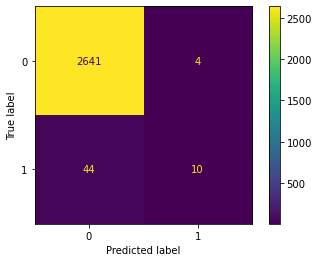

In [16]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

In [38]:
pipe_gs = Pipeline([
    ('cv', CountVectorizer(ngram_range=(1,2), min_df=2)),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=20))
])
pipe_gs.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(min_df=2, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(n_jobs=-1, random_state=20))])

In [39]:
get_metrics(pipe_gs)

The training balanced accuracy score is 0.9012345679012346
The testing balanced accuracy score is 0.5903241615907022
The training f1 score is 0.8904109589041096
The testing f1 score is 0.2631578947368421
The training accuracy score is 0.9960474308300395
The testing accuracy score is 0.9792515746572805


### Bring in other word processing

In [40]:
import nltk
nltk.download('wordnet') 
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilyfuller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/emilyfuller/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emilyfuller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
lemmatizer = WordNetLemmatizer()

In [42]:
class LemmaTokenizer():
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [44]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

In [45]:
cvl = CountVectorizer(tokenizer=lemma_tokenizer)

In [46]:
cvl.fit(X_train)

/Users/emilyfuller/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(tokenizer=<function lemma_tokenizer at 0x7fca4aae0c10>)

In [47]:
X_train_cvl = cvl.transform(X_train)

In [48]:
pd.DataFrame(X_train_cvl.A, columns = cvl.get_feature_names_out()).head()

,sponge,!,#,$,%,&,','','all-powerful,'baked,...,🥰✌🏻,🥲,🦀,🦄💕,🧁🍪,🧇,🧑🏻‍🍳🥸,🫐,🫐🍰,🫖
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Gride search over LR (balanced) with the new tokenizer

In [49]:
pipe_lrcb = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegression(max_iter= 1000, class_weight='balanced'))
])

In [50]:
params_lrcb = {
    'cv__ngram_range': [(1,1),(1,2),(2,2)],
   # 'cv__stop_words' :[None, 'english'],
    'cv__min_df':[1, 2, 4],
    'cv__lowercase':[True, False],
    'cv__tokenizer' :[None, lemma_tokenizer],
    'lr__n_jobs':[-1]
}

In [51]:
gs_lrcb = GridSearchCV(
    pipe_lrcb,
    param_grid= params_lrcb,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

In [52]:
gs_lrcb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'cv__lowercase': [True, False],
                         'cv__min_df': [1, 2, 4],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cv__tokenizer': [None,
                                           <function lemma_tokenizer at 0x7fca4aae0c10>],
                         'lr__n_jobs': [-1]},
             scoring='balanced_accuracy')

In [53]:
gs.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(lowercase=False, ngram_range=(2, 2))),
                ('rf', RandomForestClassifier(n_jobs=-1, random_state=20))])

In [54]:
get_metrics(gs_lrcb)

The training balanced accuracy score is 0.9212406676065192
The testing balanced accuracy score is 0.6197822586291395
The training f1 score is 0.28305400372439476
The testing f1 score is 0.10270270270270271
The training accuracy score is 0.904891304347826
The testing accuracy score is 0.8769914783253057


There is no substantive improvement with the grid searched lr balanced model compared to the 

#### gridsearch over rfc with the new tokenizer

In [56]:
pipe_rfc

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', RandomForestClassifier(random_state=20))])

In [57]:
params_rfc  = {
    'cv__ngram_range': [(1,1),(1,2),(2,2)],
    'cv__min_df':[1, 2, 4],
    'cv__lowercase':[True, False],
    'cv__tokenizer' :[None, lemma_tokenizer],
    'rf__n_jobs':[-1],
}

In [58]:
gs_rfc = GridSearchCV(
    pipe_rfc,
    param_grid= params_rfc,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

In [59]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=20))]),
             n_jobs=-1,
             param_grid={'cv__lowercase': [True, False],
                         'cv__min_df': [1, 2, 4],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cv__tokenizer': [None,
                                           <function lemma_tokenizer at 0x7fca4aae0c10>],
                         'rf__n_jobs': [-1]},
             scoring='balanced_accuracy')

In [60]:
gs_rfc.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(tokenizer=<function lemma_tokenizer at 0x7fca4aae0c10>)),
                ('rf', RandomForestClassifier(n_jobs=-1, random_state=20))])

In [62]:
get_metrics(gs_rfc)

The training balanced accuracy score is 0.9226504464299607
The testing balanced accuracy score is 0.5907022334243506
The training f1 score is 0.9072847682119205
The testing f1 score is 0.2702702702702703
The training accuracy score is 0.9965415019762845
The testing accuracy score is 0.9799925898480919


There is no substantive improvement from the original rfc pipe model

### Try strategies to overcome the imbalanced data

In [63]:
pipe_ros = Pipeline([
    ('cv', CountVectorizer()),
    ('ros', RandomOverSampler()),
    ('rfc', RandomForestClassifier())
])

pipe_ros.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('ros', RandomOverSampler()),
                ('rfc', RandomForestClassifier())])

In [64]:
get_metrics(pipe_ros)

The training balanced accuracy score is 0.9938240483992942
The testing balanced accuracy score is 0.5995799201848351
The training f1 score is 0.7677725118483413
The testing f1 score is 0.1889763779527559
The training accuracy score is 0.9878952569169961
The testing accuracy score is 0.9618377176732124


Adding the basic random oversampling slightly improves the RFC metrics. We may be able to further improve by tuning the parameters

In [65]:
params_ros  = {
    'cv__ngram_range': [(1,1),(1,2),(2,2)],
    'cv__min_df':[1, 2, 4],
    'cv__lowercase':[True, False],
    'cv__tokenizer' :[None, lemma_tokenizer],
    'ros__sampling_strategy':[0, .25, .5, .75, 1],
    'rfc__n_jobs':[-1],
}

In [66]:
gs_ros = GridSearchCV(
    pipe_ros,
    param_grid= params_ros,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

gs_ros.fit(X_train, y_train)

/Users/emilyfuller/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emilyfuller/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilyfuller/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/emilyfuller/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 226, in _fit
   

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('ros', RandomOverSampler()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cv__lowercase': [True, False],
                         'cv__min_df': [1, 2, 4],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cv__tokenizer': [None,
                                           <function lemma_tokenizer at 0x7fca4aae0c10>],
                         'rfc__n_jobs': [-1],
                         'ros__sampling_strategy': [0, 0.25, 0.5, 0.75, 1]},
             scoring='balanced_accuracy')

In [67]:
get_metrics(gs_ros)

The training balanced accuracy score is 0.9025081925888581
The testing balanced accuracy score is 0.5832808233564377
The training f1 score is 0.1731694281133084
The testing f1 score is 0.05904059040590406
The training accuracy score is 0.8089179841897233
The testing accuracy score is 0.7165616895146351


In [68]:
gs_ros.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(min_df=4, ngram_range=(2, 2))),
                ('ros', RandomOverSampler(sampling_strategy=1)),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

In [69]:
gs_ros.best_params_

{'cv__lowercase': True,
 'cv__min_df': 4,
 'cv__ngram_range': (2, 2),
 'cv__tokenizer': None,
 'rfc__n_jobs': -1,
 'ros__sampling_strategy': 1}